In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

In [13]:
# Función para gráficar histogramas de variables numéricas (hecho con ayuda de deepseek r1)
def plot_numeric_analysis(df, numeric_cols, figsize=(15, 10)):
    """Gráfica histogramas de variables numéricas, adaptando los ejes a la data."""
    if not numeric_cols:
        print("No hay columnas numéricas para graficar.")
        return

    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    if len(numeric_cols) <= 2:
        figsize = (8, 5)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Análisis de Variables Numéricas', fontsize=16)

    # Aplanar los ejes para simplificar la iteración
    axes = np.array(axes).flatten() if isinstance(axes, np.ndarray) else np.array([axes])

    for idx, col in enumerate(numeric_cols):
        # Se extrae la data de la columna ignorando valores nulos
        data = df[col].dropna()
        # Se calcula un margen del 5% del rango para que el gráfico no esté muy pegado a los bordes
        if not data.empty:
            margin = 0.05 * (data.max() - data.min())
            x_min = data.min() - margin
            x_max = data.max() + margin
        else:
            x_min, x_max = 0, 1

        # Graficamos el histograma usando bins automáticos para mejor adaptación
        sns.histplot(data=df, x=col, ax=axes[idx], bins='auto')
        axes[idx].set_title(f'Distribución de {col}')
        axes[idx].set_xlim(x_min, x_max)

    # Ocultar subplots no utilizados
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)

    # Ajustamos el layout dejando espacio para el título general
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Función para detectar outlayers con el método IQR, extremos y no extremos
def iqr_method(column):
    """Detecta outliers usando el método IQR."""
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    extreme_lower_bound = q1 - 3 * iqr
    extreme_upper_bound = q3 + 3 * iqr
    return pd.Series([column>upper_bound, column<lower_bound, column>extreme_upper_bound, column<extreme_lower_bound], 
                     index=['outliers_upper', 'outliers_lower', 'extreme_upper', 'extreme_lower'])

# Función para realizar un análisis exploratorio de una tabla (mejorado con ayuda de claude 3.7 sonnet)
def analisis_exploratorio(name, df):
    """Realiza un análisis exploratorio de una tabla."""
    total_chars = 125
    print("="*total_chars)
    string = f"Análisis de la tabla {name}"
    print('|' + string.center(total_chars-2) + '|')
    print("="*total_chars)
    print(f"Dimensiones: {df.shape}")
    
    # Expresión regular para identificar columnas ID
    id_pattern = re.compile(
        r'^id_.*|.*_id$|^id$',  # Empieza con id_, termina con _id, o es exactamente id
        flags=re.IGNORECASE
    )
    id_cols = [col for col in df.columns if id_pattern.fullmatch(col)]
    
    # Separar columnas numéricas y no numéricas
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in id_cols]
    non_numeric_cols = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
    
    # Normalizar strings y manejar IDs
    for col in non_numeric_cols:
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].apply(lambda x: x.lower().strip() if pd.notna(x) else x)
    
    # Agregar IDs a no numéricas para estadísticas especiales
    non_numeric_cols += id_cols

    non_numeric_stats = []
    if non_numeric_cols:
        for col in non_numeric_cols:
            stats = {
                'Columna': col,
                'Valores Únicos': df[col].nunique(),
                'Media': '-',
                'Desviación Estándar': '-',
                'Mínimo': df[col].min() if col in id_cols else '-',
                'Mediana': '-',
                'Máximo': df[col].max() if col in id_cols else '-'
            }
            non_numeric_stats.append(stats)
    
    numeric_stats = []
    cols_to_remove = []
    if numeric_cols:
        for col in numeric_cols:
            if df[col].nunique() == 2 and set(df[col].dropna().unique()).issubset({0, 1}):
                df[col] = df[col].astype('boolean')
                cols_to_remove.append(col)
            else:
                numeric_stats.append({
                    'Columna': col,
                    'Valores Únicos': df[col].nunique(),
                    'Media': df[col].mean(),
                    'Desviación Estándar': df[col].std(),
                    'Mínimo': df[col].min(),
                    'Mediana': df[col].median(),
                    'Máximo': df[col].max()
                })
        # Remover columnas convertidas a boolean
        numeric_cols = [col for col in numeric_cols if col not in cols_to_remove]
    
    # Crear un único DataFrame con todas las estadísticas
    all_stats = []
    
    for col in df.columns:
        is_numeric = col in numeric_cols
        
        stats = {
            'Columna': col,
            'Valores Únicos': df[col].nunique(),
            'Media': df[col].mean() if is_numeric else '-',
            'Desviación Estándar': df[col].std() if is_numeric else '-',
            'Mínimo': df[col].min() if is_numeric or col in id_cols else '-',
            'Mediana': df[col].median() if is_numeric else '-',
            'Máximo': df[col].max() if is_numeric or col in id_cols else '-',
            'Tipos de datos': df[col].apply(type).unique() if len(df[col].apply(type).unique()) == 1 else '\n'.join(str(t) for t in df[col].apply(type).unique()),
            'NaN/Null': df[col].isnull().sum(),
            'Duplicados únicos': len(df[(df.duplicated(subset=[col], keep='first'))&(df[col].notnull())]),
            'Duplicados totales': len(df[(df.duplicated(subset=[col], keep=False))&(df[col].notnull())])
        }
        
        # Agregar información de outliers solo para columnas numéricas
        if is_numeric:
            iqr_stats = iqr_method(df[col])
            stats.update({
                'Outlayers (IQR extreme_lower)': iqr_stats['extreme_lower'].sum(),
                'Outlayers (IQR lower)': iqr_stats['outliers_lower'].sum(),
                'Outlayers (IQR upper)': iqr_stats['outliers_upper'].sum(),
                'Outlayers (IQR extreme_upper)': iqr_stats['extreme_upper'].sum()
            })
        else:
            stats.update({
                'Outlayers (IQR extreme_lower)': '-',
                'Outlayers (IQR lower)': '-',
                'Outlayers (IQR upper)': '-',
                'Outlayers (IQR extreme_upper)': '-'
            })
            
        all_stats.append(stats)
    
    # Crear un único DataFrame con todas las estadísticas
    all_stats_df = pd.DataFrame(all_stats).set_index('Columna')
    inconsistencias_stats_df = all_stats_df.T
    
    print('\nEstadísticas descriptivas y problemas de calidad:')
    print(inconsistencias_stats_df.to_markdown(index=True))
    
    if numeric_cols:
        plot_numeric_analysis(df, numeric_cols)
    return


|                                                 Análisis de la tabla Churn                                                |
Dimensiones: (10000, 14)

Estadísticas descriptivas y problemas de calidad:
|                               | RowNumber          | CustomerId       | Surname         | CreditScore       | Geography       | Gender          | Age                | Tenure            | Balance            | NumOfProducts      | HasCrCard        | IsActiveMember   | EstimatedSalary   | Exited           |
|:------------------------------|:-------------------|:-----------------|:----------------|:------------------|:----------------|:----------------|:-------------------|:------------------|:-------------------|:-------------------|:-----------------|:-----------------|:------------------|:-----------------|
| Valores Únicos                | 10000              | 10000            | 2931            | 460               | 3               | 2               | 70                 | 11           

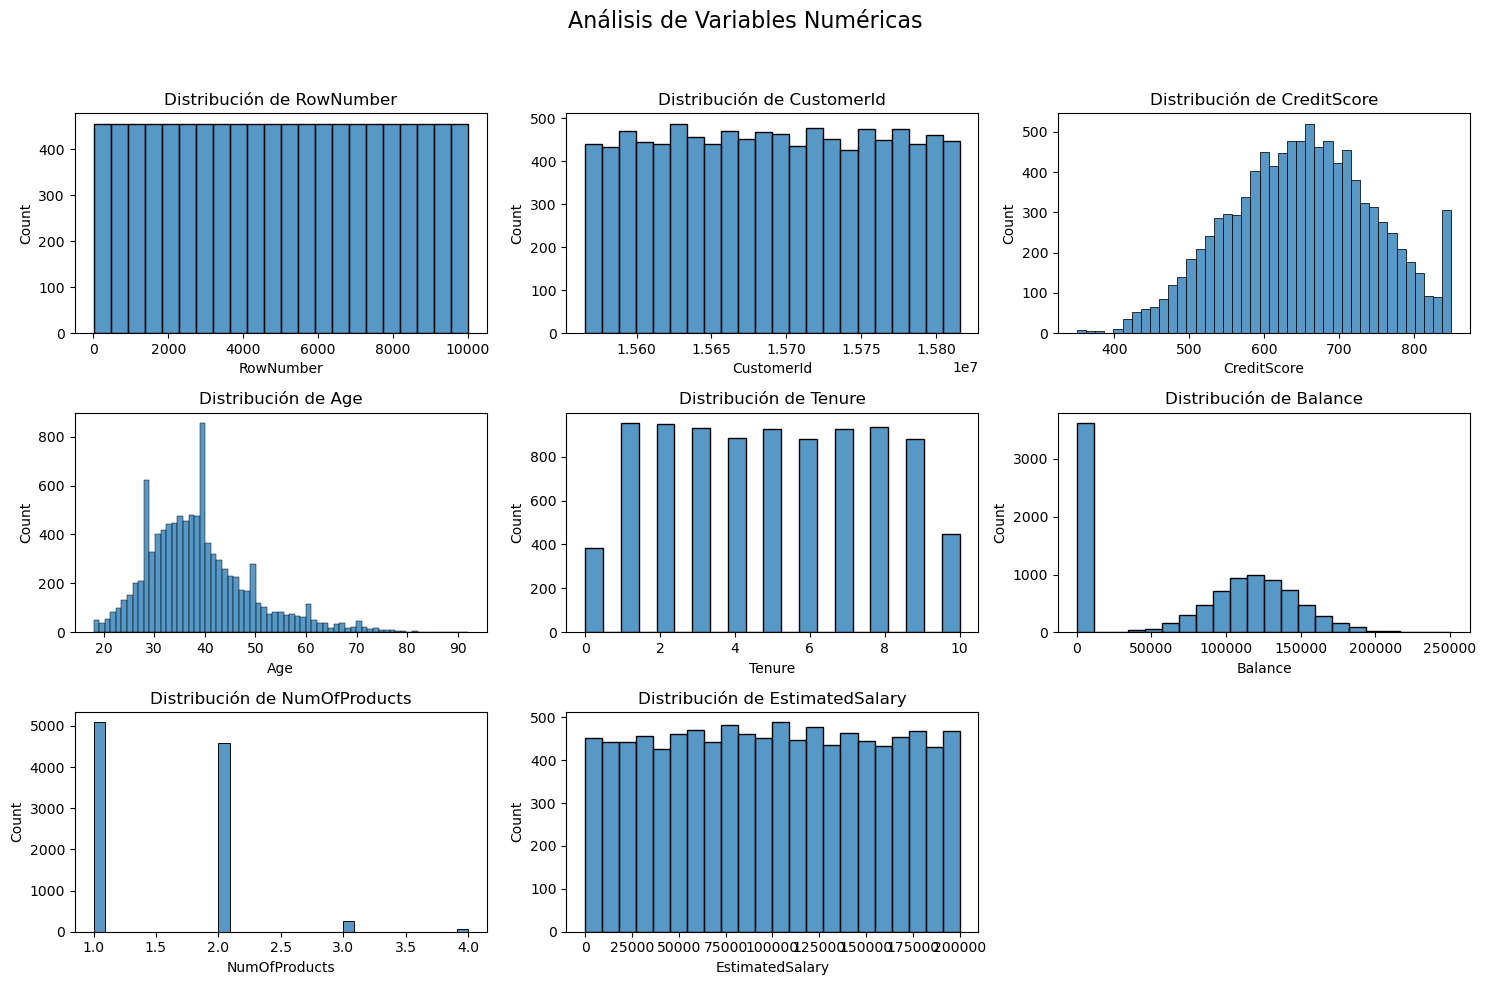

In [14]:
source_file = '../data/raw/Churn.csv'
df = pd.read_csv(source_file, low_memory=False)
analisis_exploratorio('Churn', df)

|                                                 Análisis de la tabla Calls                                                |
Dimensiones: (137735, 4)

Estadísticas descriptivas y problemas de calidad:
|                               | id              | user_id         | call_date       | duration          |
|:------------------------------|:----------------|:----------------|:----------------|:------------------|
| Valores Únicos                | 137735          | 481             | 351             | 2802              |
| Media                         | -               | -               | -               | 6.745927033796782 |
| Desviación Estándar           | -               | -               | -               | 5.839241137578812 |
| Mínimo                        | 1000_145        | 1000            | -               | 0.0               |
| Mediana                       | -               | -               | -               | 5.98              |
| Máximo                        | 1499_99 

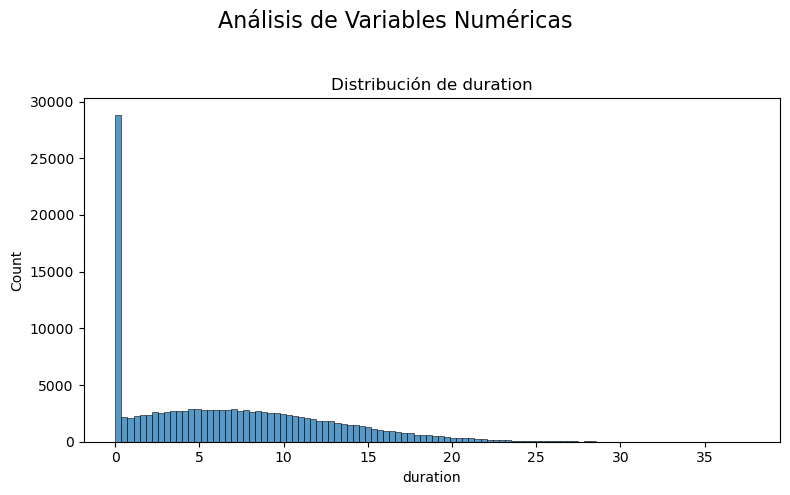

In [15]:
source_file = '../data/raw/megaline_calls.csv'
df = pd.read_csv(source_file, low_memory=False)
analisis_exploratorio('Calls', df)

|                                               Análisis de la tabla Internet                                               |
Dimensiones: (104825, 4)

Estadísticas descriptivas y problemas de calidad:
|                               | id              | user_id         | session_date    | mb_used            |
|:------------------------------|:----------------|:----------------|:----------------|:-------------------|
| Valores Únicos                | 104825          | 489             | 351             | 57624              |
| Media                         | -               | -               | -               | 366.71370102551873 |
| Desviación Estándar           | -               | -               | -               | 277.1705420373537  |
| Mínimo                        | 1000_13         | 1000            | -               | 0.0                |
| Mediana                       | -               | -               | -               | 343.98             |
| Máximo                        | 1

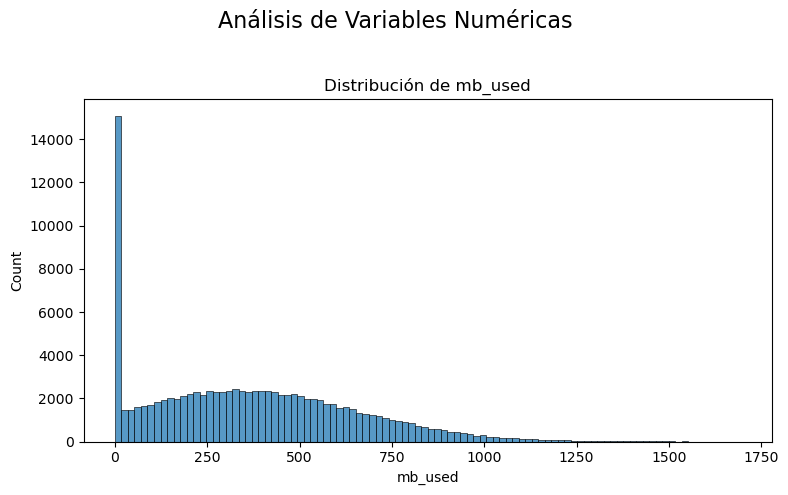

In [16]:
source_file = '../data/raw/megaline_internet.csv'
df = pd.read_csv(source_file, low_memory=False)
analisis_exploratorio('Internet', df)

In [17]:
source_file = '../data/raw/megaline_messages.csv'
df = pd.read_csv(source_file, low_memory=False)
analisis_exploratorio('Messages', df)

|                                               Análisis de la tabla Messages                                               |
Dimensiones: (76051, 3)

Estadísticas descriptivas y problemas de calidad:
|                               | id              | user_id         | message_date    |
|:------------------------------|:----------------|:----------------|:----------------|
| Valores Únicos                | 76051           | 402             | 351             |
| Media                         | -               | -               | -               |
| Desviación Estándar           | -               | -               | -               |
| Mínimo                        | 1000_125        | 1000            | -               |
| Mediana                       | -               | -               | -               |
| Máximo                        | 1497_68         | 1497            | -               |
| Tipos de datos                | [<class 'str'>] | [<class 'int'>] | [<class 'str'>] |
| NaN/N

|                                                 Análisis de la tabla Plans                                                |
Dimensiones: (2, 8)

Estadísticas descriptivas y problemas de calidad:
|                               | messages_included   | mb_per_month_included   | minutes_included   | usd_monthly_pay   | usd_per_gb         | usd_per_message     | usd_per_minute      | plan_name       |
|:------------------------------|:--------------------|:------------------------|:-------------------|:------------------|:-------------------|:--------------------|:--------------------|:----------------|
| Valores Únicos                | 2                   | 2                       | 2                  | 2                 | 2                  | 2                   | 2                   | 2               |
| Media                         | 525.0               | 23040.0                 | 1750.0             | 45.0              | 8.5                | 0.02                | 0.02               

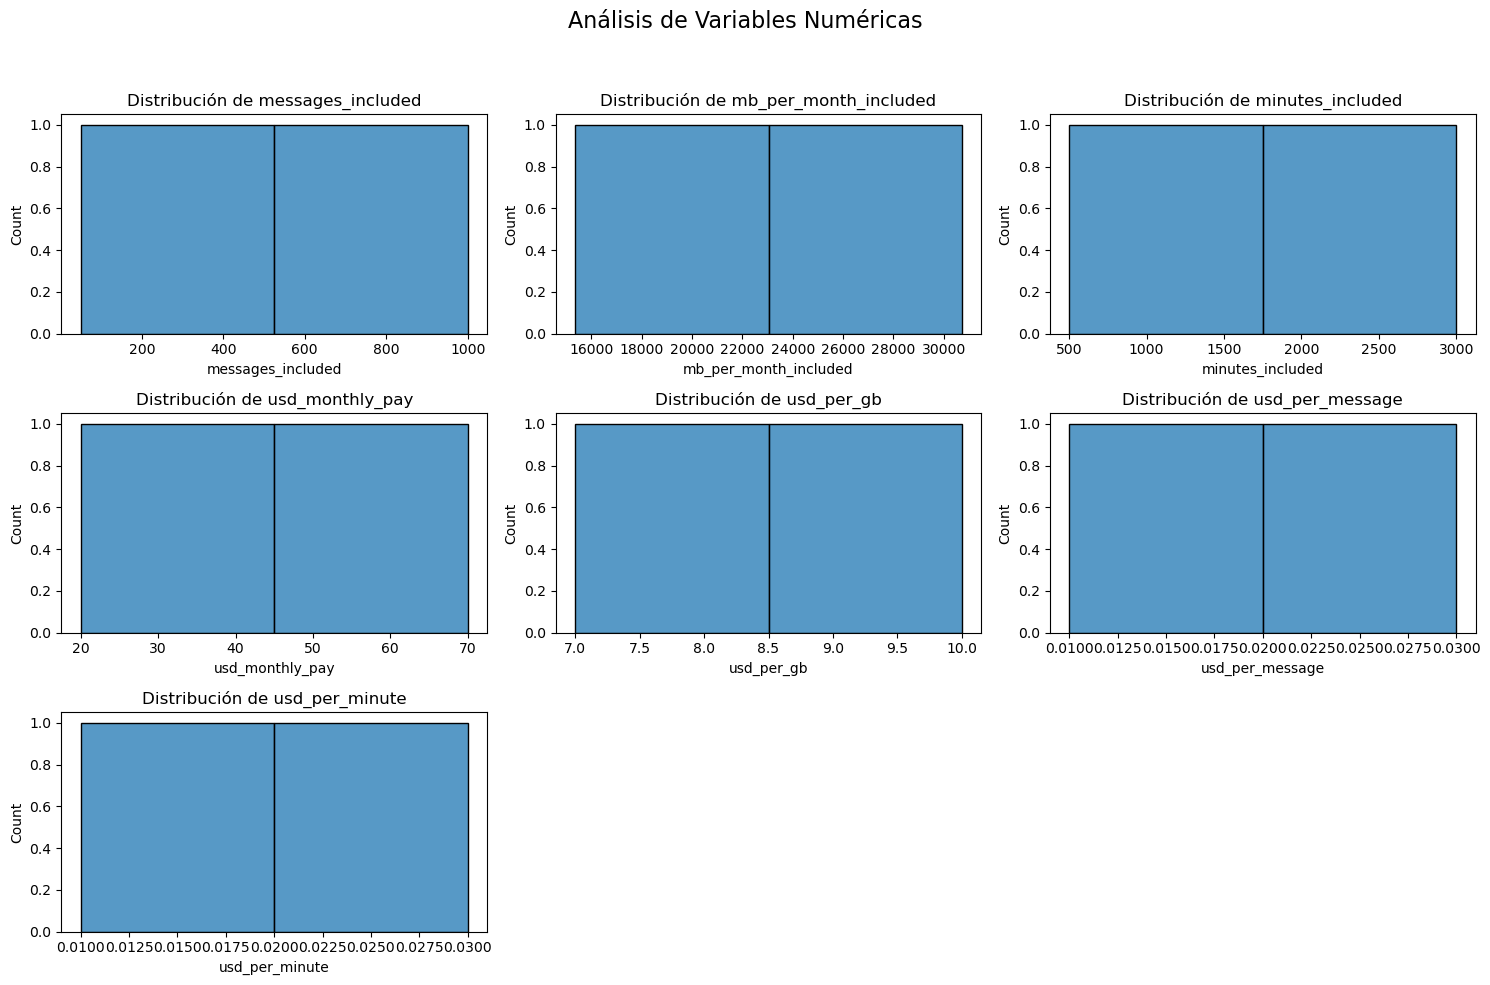

In [18]:

source_file = '../data/raw/megaline_plans.csv'
df = pd.read_csv(source_file, low_memory=False)
analisis_exploratorio('Plans', df)

|                                                 Análisis de la tabla Users                                                |
Dimensiones: (500, 8)

Estadísticas descriptivas y problemas de calidad:
|                               | user_id         | first_name      | last_name       | age                | city            | reg_date        | plan            | churn_date      |
|:------------------------------|:----------------|:----------------|:----------------|:-------------------|:----------------|:----------------|:----------------|:----------------|
| Valores Únicos                | 500             | 458             | 399             | 58                 | 73              | 266             | 2               | 29              |
| Media                         | -               | -               | -               | 45.486             | -               | -               | -               | -               |
| Desviación Estándar           | -               | -               | -      

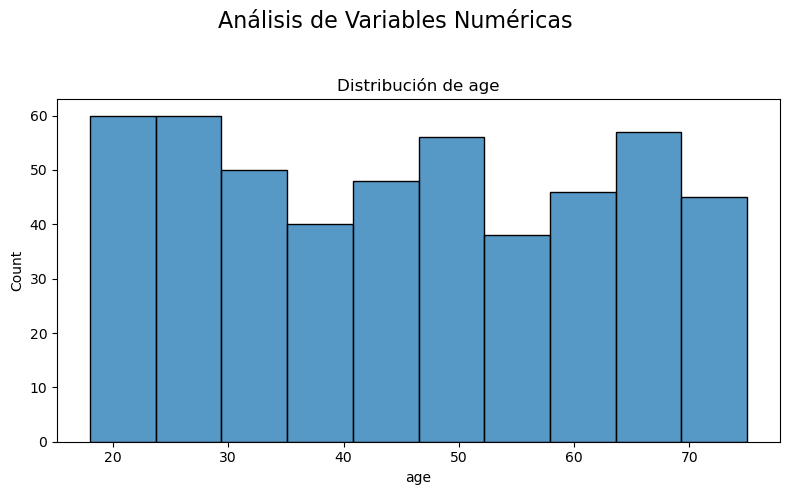

In [19]:
source_file = '../data/raw/megaline_users.csv'
df = pd.read_csv(source_file, low_memory=False)
analisis_exploratorio('Users', df)